# Solving RBC Model with Dolo.jl

This worksheet demonstrates how to solve the RBC model with the [dolo](http://econforge.github.io/dolo/) library 
and how to generates impulse responses and stochastic simulations from the solution.

- This notebook is modified from `rbc_model` example distributed with dolo in : ``examples\notebooks\``.
- The model file(.yaml file) is in : ``examples\global_models\``


# YAML file for model specification

Dolo uses [YAML](http://www.yaml.org/spec/1.2/spec.html#Introduction) file which we can read locally or pull off the web. 

The YAML file works similarly to `.mod` file in Dynare, which does a configuration of the model. It includes the following:

1. In `symbols` section, specify different kinds of variables in the model:
    - `parameters:` deep parameters of the model, exp: $\beta$
    - `exogenous:` exogenous shocks of the model, exp: $\epsilon$ (iid shock on productivity)
    - `states:` state variables of the model, exp: $k$ (capital stock)
    - `controls:` control/choice variables of the model, exp: $n$ (labor)
    - `values:` value function in terms of Bellman Equation; `rewards:` utility function.

2. "auxiliary variables": these are variables that can be expressed as a closed form of the formerly-defined variables. Defining these variables will help to simplify the system of equations and sometimes these variables have particular economic meaning. These variables are defined in `definitions`. Once defined, one could use them in model equations.

3. Model section, specified using command `equations:`, consist of:

   Essential parts:
    
    - `arbitrage:` Euler Equation, notice the EE specification is usually accompanied by complementarity condition included in the `arbitrage` configuration.

    - `transition:` Law of motion, this should include both things like capital accumulation and process of shocks.

    Aditionals:

    - `expectations:` A function of purely expected future values.

    - `felicity:` defining utility function; `values:` defining value function;

    - `direct response:` additional equations that may speed up computation.


For more options in model specification please refer to http://www.econforge.org/Dolo.jl/latest/model_specification.html

# Example of RBC

In [5]:
using Dolo

In [2]:
filename="rbc_dtcc_iid.yaml"

"rbc_dtcc_iid.yaml"

In [7]:
;cat $filename

name: Real Business Cycle

model_type: dtcc

symbols:

   exogenous: [e_z]
   states: [z, k]
   controls: [n, i]
   expectations: [m]
   values: [V]
   parameters: [beta, sigma, eta, chi, delta, alpha, rho, zbar, sig_z]
   rewards: [u]

definitions:
    y: exp(z)*k^alpha*n^(1-alpha)
    c: y - i
    rk: alpha*y/k
    w: (1-alpha)*y/n

equations:

    arbitrage:
        - chi*n^eta*c^sigma - w                      | 0.0 <= n <= inf
        - 1 - beta*(c/c(1))^(sigma)*(1-delta+rk(1))  | 0.0 <= i <= inf


    transition:
        - z = rho*z(-1) + e_z
        - k = (1-delta)*k(-1) + i(-1)

    value:
        - V = c^(1-sigma)/(1-sigma) - chi*n^(1+eta)/(1+eta) + beta*V(1)

    felicity:
        - u =  c^(1-sigma)/(1-sigma) - chi*n^(1+eta)/(1+eta)

    expectation:
        - m = beta/c(1)^sigma*(1-delta+rk(1))

    direct_response:
        - n = ((1-alpha)*exp(z)*k^alpha*m/chi)^(1/(eta+alpha))
        - i = exp(z)*k^alpha*n^(1-alpha) - (m)^(-1/sigma)

calibration:

    # parameters
    beta 

`yaml_import(filename)` reads the YAML file and generates a model object. 

In [8]:
model = yaml_import(filename)

name,Real Business Cycle
filename,rbc_dtcc_iid.yaml
Type,Equation
expectation,\[m_{t} = \frac{\beta}{\left(c_{t+1}\right)^{\sigma}} \left(1-\delta\right)+rk_{t+1}\]
value,\[V_{t} = \left(\frac{\left(c_{t}\right)^{\left(1-\sigma\right)}}{\left(1-\sigma\right)}-\frac{\chi \left(n_{t}\right)^{1+\eta}}{1+\eta}\right)+\beta V_{t+1}\]
transition,"\[z_{t} = \rho z_{t-1}+e_{z,t}\]"
,\[k_{t} = \left(1-\delta\right) k_{t-1}+i_{t-1}\]
direct_response,\[n_{t} = \left(\frac{\left(1-\alpha\right) \text{exp}\left(z_{t}\right) \left(k_{t}\right)^{\alpha} m_{t}}{\chi}\right)^{\frac{1}{\eta+\alpha}}\]
,\[i_{t} = \left(\text{exp}\left(z_{t}\right) \left(k_{t}\right)^{\alpha} \left(n_{t}\right)^{\left(1-\alpha\right)}-\left(m_{t}\right)^{\frac{-1}{\sigma}}\right)\]
felicity,\[u_{t} = \left(\frac{\left(c_{t}\right)^{\left(1-\sigma\right)}}{\left(1-\sigma\right)}-\frac{\chi \left(n_{t}\right)^{1+\eta}}{1+\eta}\right)\]
arbitrage,\[\left(\chi \left(n_{t}\right)^{\eta} \left(c_{t}\right)^{\sigma}-w_{t}\right)\]


# Steady State values

The model file already has values for steady-state variables stated in the calibration section so we can go ahead and check that they are correct by computing the model equations at the steady state.

In [13]:
residuals(model)

Dict{Symbol,Array{Float64,1}} with 2 entries:
  :transition => [0.0, 0.0]
  :arbitrage  => [-4.44089e-16, 0.0]

Or more specifically one can check the s.s. values through command `model.calibration`

In [51]:
model.calibration[:controls]

2-element Array{Float64,1}:
 0.33   
 0.20961

# Solving the model

Dolo offers several [algorithms](http://www.econforge.org/Dolo.jl/latest/algos.html) to solve the model. Here we present a way of policy function iteration using command `time_iteration`, and its alternative faster command `improved_time_iteration`.

In [17]:
@time sol_global = time_iteration(model)

------------------------------------------------------------------
It    ϵₙ              ηₙ=|xₙ-xₙ₋₁|    λₙ=ηₙ/ηₙ₋₁      Time            Newton steps
------------------------------------------------------------------
1     1.19e+00        1.76e-01        NaN             4.14e-01        8    
2     1.28e-01        4.73e-02        2.69e-01        1.34e-02        5    
3     7.77e-02        3.50e-02        7.40e-01        1.47e-02        5    
4     5.21e-02        2.62e-02        7.49e-01        2.92e-02        5    
5     3.70e-02        1.99e-02        7.59e-01        1.36e-02        4    
6     2.72e-02        1.53e-02        7.69e-01        1.29e-02        4    
7     2.06e-02        1.19e-02        7.79e-01        1.12e-02        4    
8     1.59e-02        9.40e-03        7.89e-01        1.12e-02        4    
9     1.25e-02        7.50e-03        7.98e-01        2.13e-02        4    
10    9.94e-03        6.06e-03        8.08e-01        1.18e-02        4    
11    8.04e-03        4

Results of Time Iteration Algorithm
 * Complementarities: true
 * Discretized Process type: Dolo.DiscretizedIIDProcess
 * Decision Rule type: Dolo.CubicDR{Dolo.EmptyGrid,Dolo.CartesianGrid{2},2,2}
 * Number of iterations: 77
 * Convergence: true
   * |x - x'| < 1.0e-07: true


... and we get the decision rule:

In [18]:
dr_global = sol_global.dr

Dolo.CubicDR{Dolo.EmptyGrid,Dolo.CartesianGrid{2},2,2}


Or we could try the new improved time iteration algorithm

In [19]:
@time sol_global_fast = improved_time_iteration(model)

------------------------------------------------------------------------------------------------------------------------
N	f_x		d_x	Time_residuals	Time_inversion	Time_search	Lambda_0	N_invert	N_search	
------------------------------------------------------------------------------------------------------------------------
1      1.188337e+00 2.858984e-01     0.0029         0.0060         0.00275        0.000           42               3    
2      8.783760e-01 7.686155e-02     0.0111         0.0051         0.00097        0.000           42               1    
3      1.045266e-01 0.000000e+00     0.0033         0.0094         0.00133        0.000           42               1    
4      2.949816e-02 2.730166e-03     0.0063         0.0145         0.00077        0.000           42               1    
5      9.993267e-04 0.000000e+00     0.0025         0.0067         0.00141        0.000           42               1    
6      1.753739e-06 2.050184e-07     0.0031         0.0078         0.001

Results of Improved Time Iteration Algorithm
 * Number of iterations: 7
 * Complementarities: true
 * Decision Rule type: Dolo.CubicDR{Dolo.EmptyGrid,Dolo.CartesianGrid{2},2,2}
 * Convergence: true
 * Contractivity: 0.0
   * |x - x'| < 1.0e-08: true


# Decision rule(optional)

Here we plot optimal investment and labour for different levels of capital.

In [20]:
tab_global = Dolo.tabulate(model, dr_global, :k)

2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:e_z, :z, :k, :n, :i, :w, :rk, :y, :c]
    :k, [8.41948, 8.43838, 8.45728, 8.47618, 8.49508, 8.51398, 8.53287, 8.55177, 8.57067, 8.58957  …  10.1204, 10.1393, 10.1582, 10.1771, 10.196, 10.2149, 10.2338, 10.2527, 10.2716, 10.2905]
And data, a 9×100 Array{Float64,2}:
 0.0        0.0        0.0        …   0.0         0.0         0.0      
 0.0        0.0        0.0            0.0         0.0         0.0      
 8.41948    8.43838    8.45728       10.2527     10.2716     10.2905   
 0.34526    0.344932   0.344604       0.316985    0.316727    0.316469 
 0.243734   0.243535   0.243336       0.224283    0.224083    0.223883 
 1.92234    1.92437    1.92639    …   2.11012     2.11198     2.11383  
 0.0388267  0.0387438  0.0386611      0.0321328   0.0320757   0.0320187
 0.990608   0.990711   0.990812       0.998327    0.998388    0.998448 
 0.746874   0.747176   0.747476       0.774044    0.774305    0.774565 

In [22]:
Dolo.tabulate(model, dr_global,:k)[:n]

1-dimensional AxisArray{Float64,1,...} with axes:
    :k, [8.41948, 8.43838, 8.45728, 8.47618, 8.49508, 8.51398, 8.53287, 8.55177, 8.57067, 8.58957  …  10.1204, 10.1393, 10.1582, 10.1771, 10.196, 10.2149, 10.2338, 10.2527, 10.2716, 10.2905]
And data, a 100-element Array{Float64,1}:
 0.34526 
 0.344932
 0.344604
 0.344277
 0.34395 
 0.343623
 0.343297
 0.342971
 0.342646
 0.342323
 0.342   
 0.341678
 0.341358
 ⋮       
 0.319326
 0.319063
 0.318802
 0.318541
 0.31828 
 0.31802 
 0.317761
 0.317502
 0.317244
 0.316985
 0.316727
 0.316469

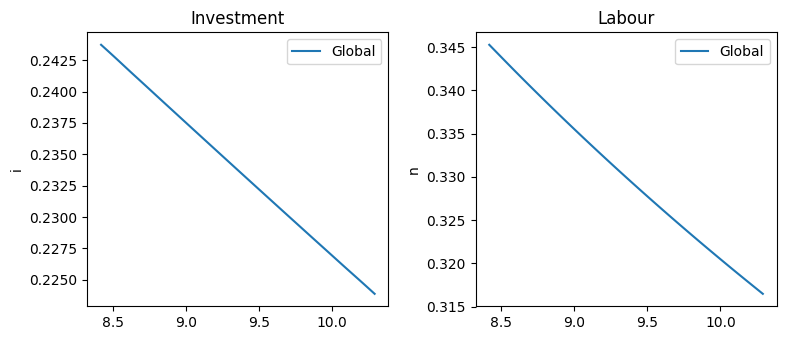

In [21]:
using PyPlot

figure(figsize=(8,3.5))

subplot(121)
plot(tab_global[:k], tab_global[:i], label="Global")
# plot(tab_pert['k'], tab_pert['i'], label='Perturbation')
ylabel("i")
title("Investment")
legend()

subplot(122)
plot(tab_global[:k], tab_global[:n], label="Global")
# plot(tab_pert['k'], tab_pert['n'], label='Perturbation')
ylabel("n")
title("Labour")
legend()

tight_layout()
show()

Dolo also offers a convenient way to change parameter values in configuration. Use `set_calibration!(model,para=val)` command one can replace the original parameter value in the model file.

We can use this feature to do comparative stat easily. For example, let's consider a change in the value of $\delta$ in the model:

In [35]:
original_delta=model.calibration.flat[:delta] 

drs = []
delta_values = linspace(0.02, 0.05,5)
for val in delta_values
    print(val)
    set_calibration!(model, delta=val)
    push!(drs,time_iteration(model, verbose=false).dr)
end


0.020.02750.0350.04250.05

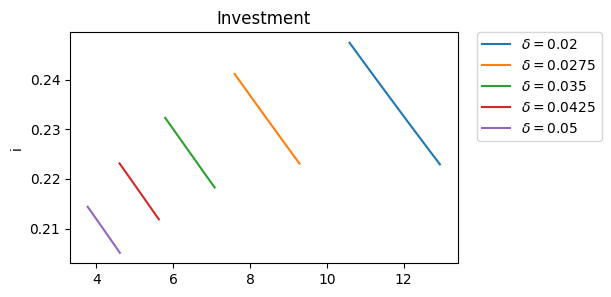

Dolo.ModelCalibration(Dolo.FlatCalibration(:alpha=>0.33,:n=>0.33,:beta=>0.99,:eta=>1.0,:sigma=>5.0,:delta=>0.025,:rho=>0.8,:zbar=>0.0,:z=>0.0,:sig_z=>0.016…), Dolo.GroupedCalibration(:values=>[-27.2881],:controls=>[0.33, 0.233874],:states=>[0.0, 9.35498],:exogenous=>[0.0],:rewards=>[-2.04921],:expectations=>[3.91339],:parameters=>[0.99, 5.0, 1.0, 23.9579, 0.025, 0.33, 0.8, 0.0, 0.016]), Dict(:alpha=>(:parameters, 6),:n=>(:controls, 1),:rho=>(:parameters, 7),:V=>(:values, 1),:delta=>(:parameters, 5),:eta=>(:parameters, 3),:sigma=>(:parameters, 2),:k=>(:states, 2),:sig_z=>(:parameters, 9),:z=>(:states, 1)…), DataStructures.OrderedDict(:values=>Symbol[:V],:controls=>Symbol[:n, :i],:states=>Symbol[:z, :k],:exogenous=>Symbol[:e_z],:rewards=>Symbol[:u],:expectations=>Symbol[:m],:parameters=>Symbol[:beta, :sigma, :eta, :chi, :delta, :alpha, :rho, :zbar, :sig_z]))

In [58]:
figure(figsize=(5,3))

for (i,dr) in enumerate(drs)
     sim = Dolo.tabulate(model, dr,:k)
     dv = delta_values[i]
     plot(sim[:k],sim[:i], label="\$\\delta=$dv\$")
end
ylabel("i")
title("Investment")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
show()

set_calibration!(model,delta=original_delta)

We find that more durable capital leads to higher steady state investment and slows the rate of convergence for capital (the slopes are roughly the same, which implies that relative to steady state capital investment responds stronger at higher $\delta$, this in addition to the direct effect of depreciation).

# Use the model to simulate

We will use the deterministic steady-state as a starting point.

In [89]:
set_calibration!(model,delta=0.05)
s0 = model.calibration[:states]
[zip(model.symbols[:states], s0)...]

2-element Array{Tuple{Symbol,Float64},1}:
 (:z, 0.0)    
 (:k, 4.19221)

We also get the covariance matrix just in case. This is a one shock model so all we have it the variance of $e_z$.

In [90]:
sigma2_ez = model.exogenous.Sigma
sigma2_ez

1×1 Array{Float64,2}:
 0.000256

## Impulse response functions

Let us plot the response of consumption and investment to a shock on productivity (to innovation `e_z`)

In [91]:

dr_global = time_iteration(model).dr
irf = response(model, dr_global, :e_z, 0.01)

------------------------------------------------------------------
It    ϵₙ              ηₙ=|xₙ-xₙ₋₁|    λₙ=ηₙ/ηₙ₋₁      Time            Newton steps
------------------------------------------------------------------
1     9.24e-01        1.28e-01        NaN             1.98e-02        7    
2     1.62e-01        4.14e-02        3.25e-01        1.73e-02        5    
3     8.99e-02        2.86e-02        6.90e-01        1.34e-02        5    
4     5.62e-02        2.03e-02        7.09e-01        2.03e-02        5    
5     3.79e-02        1.47e-02        7.27e-01        1.00e-02        4    
6     2.68e-02        1.10e-02        7.43e-01        1.02e-02        4    
7     1.96e-02        8.30e-03        7.57e-01        1.01e-02        4    
8     1.47e-02        6.39e-03        7.70e-01        1.23e-02        4    
9     1.13e-02        4.99e-03        7.81e-01        2.28e-02        4    
10    8.80e-03        3.95e-03        7.91e-01        1.36e-02        4    
11    6.96e-03        3

2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:e_z, :z, :k, :n, :i, :w, :rk, :y, :c]
    :T, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
And data, a 9×40 Array{Float64,2}:
 0.0        0.01       0.0        …  0.0         0.0         0.0       
 0.0        0.01       0.008         3.24519e-6  2.59615e-6  2.07692e-6
 4.19221    4.19238    4.20096       4.20105     4.20069     4.20035   
 0.330089   0.330999   0.330549      0.329813    0.329824    0.329834  
 0.209787   0.218194   0.216413      0.209692    0.209695    0.209699  
 1.55       1.56418    1.56281    …  1.55152     1.55145     1.55139   
 0.0601118  0.0608264  0.0605666     0.0599936   0.0599984   0.0600029 
 0.76364    0.77275    0.771023      0.763745    0.76374     0.763736  
 0.553853   0.554556   0.55461       0.554053    0.554045    0.554037  

The easiest way to plot IRF is simply using the stored `irf` values.

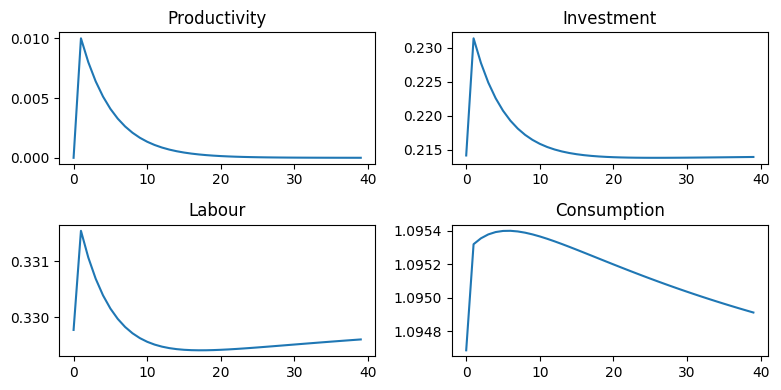

In [79]:
figure(figsize=(8,4))
subplot(221)
plot(irf[:z])
title("Productivity")
subplot(222)
plot(irf[:i])
title("Investment")
subplot(223)
plot(irf[:n])
title("Labour")
subplot(224)
plot(irf[:c])
title("Consumption")

tight_layout()

Note that the plotting is made using the wonderful [matplotlib](http://matplotlib.org/users/pyplot_tutorial.html) library. Read the online [tutorials](http://matplotlib.org/users/beginner.html) to learn how to customize the plots to your needs (e.g., using [latex](http://matplotlib.org/users/usetex.html) in annotations). If instead you would like to produce charts in Matlab, you can easily export the impulse response functions, or any other matrix, to a `.mat` file.

Actually the result of irf is The result is a superconvenient AxisArrays object. In case there is any disagreement about the meanging of signifier "superconvenient", the result can be converted to a DataFrame with the following function:

In [62]:
using AxisArrays
using DataFrames
function to_DataFrame(x::AxisArray{Float64,2})
    _axes = Dict(zip(AxisArrays.axisnames(irf), AxisArrays.axisvalues(irf)))
    colnames = _axes[:V]
    linenames = _axes[:T]
    dd = Dict(v=>irf[Axis{:V}(v)].data for v in colnames)
    return DataFrame(dd)
end

to_DataFrame (generic function with 1 method)

In [78]:
irf_df = to_DataFrame(irf)
irf_df

,c,e_z,i,k,n,rk,w,y,z
1,1.0946849604435545,0.0,0.21417594785597105,21.49753444140151,0.32977427781694035,0.020091797081018405,2.6592031809329737,1.3088609082995255,0.0
2,1.0953191355384113,0.01,0.23141129521707354,21.496735044843465,0.3315374298493025,0.02036686228099241,2.681173552591696,1.3267304307554848,0.01
3,1.0953543223671174,0.0,0.22778688682817452,21.513178989612104,0.3310620807457557,0.020296237912829227,2.6777594346168883,1.3231412091952919,0.008
4,1.0953777334361041,0.0,0.22489798361424557,21.525834086544158,0.33068573041571286,0.020240376511076366,2.6750012143303,1.3202757170503496,0.0064
5,1.0953917856587485,0.0,0.22259530594899768,21.53547372929296,0.3303883971077164,0.020196246699646474,2.672767443129333,1.3179870916077463,0.00512
6,1.0953984246096697,0.0,0.22076017571230636,21.542714297949026,0.3301541351645032,0.02016144911449727,2.67095325574627,1.316158600321976,0.004096000000000001
7,1.0953992131278036,0.0,0.21929813033850637,21.548047330681843,0.32997021469083687,0.0201340806749636,2.6694749432088316,1.31469734346631,0.0032768000000000007
8,1.0953954043997274,0.0,0.21813390941448524,21.55186498771353,0.3298264698045528,0.020112629408443466,2.6682656512590617,1.3135293138142126,0.002621440000000001
9,1.0953880020297015,0.0,0.2172075040789692,21.55448024725088,0.32971477994379117,0.020095892457026764,2.66727196531115,1.3125955061086707,0.002097152000000001
10,1.09537780881058,0.0,0.21647103614006344,21.556142948857342,0.3296286569958065,0.020082911857692065,2.666451194284703,1.3118488449506434,0.001677721600000001


## Stochastic simulations

Now we run 1000 random simulations the result is an AxisArrays indexed by:
- $T$ the number of dates
- $N$ the number of simulations
- $V$ is the number of variables
(the actual ordering of the dimensions is irrelevent if one uses the AxisArrays indexing routines)

In [85]:
sim = simulate(model, dr_global, N=1000, T=1000 )

3-dimensional AxisArray{Float64,3,...} with axes:
    :N, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
    :V, Symbol[:e_z, :z, :k, :n, :i, :w, :rk, :y, :c]
    :T, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
And data, a 1000×9×1000 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.0601118  0.76364  0.553853
 0.0  0.0  4.19221  0.330089  0.209787  1.55  0.060111

In [32]:
# actual ordering of the data: (N,V,T)
size(sim.data)

(1000, 9, 1000)

We plot the responses of consumption, investment and labour to the stochastic path of productivity.

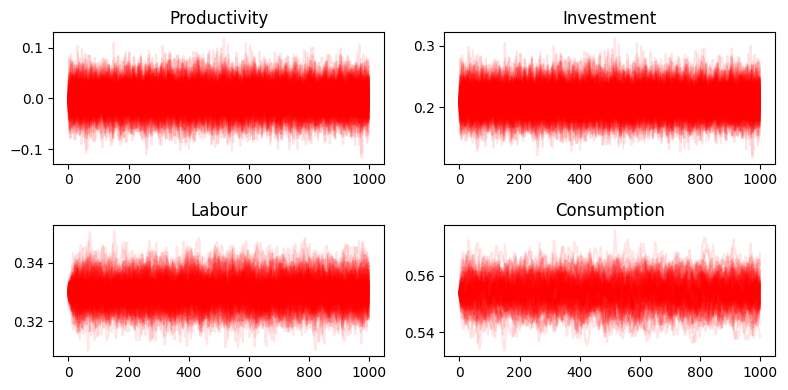

In [86]:

figure(figsize=(8,4))
for i in 500:600
    subplot(221)
    plot(sim[Axis{:N}(i),Axis{:V}(:z)], color=:red, alpha=0.1)
    subplot(222)
    plot(sim[Axis{:N}(i),Axis{:V}(:i)], color=:red, alpha=0.1)
    subplot(223)
    plot(sim[Axis{:N}(i),Axis{:V}(:n)], color=:red, alpha=0.1)
    subplot(224)
    plot(sim[Axis{:N}(i),Axis{:V}(:c)], color=:red, alpha=0.1)
end
subplot(221)
title("Productivity")
subplot(222)
title("Investment")
subplot(223)
title("Labour")
subplot(224)
title("Consumption")

tight_layout()

It's easy to compare the simulated result with the deterministic steady state value implied from the theoretical model:

In [87]:
mean(sim[Axis{:N}(600),Axis{:V}(:n)])

0.33111042476691205

In [92]:
mean(sim[Axis{:N}(600),Axis{:V}(:i)])

0.20773462691813543

In [93]:
mean(sim[Axis{:N}(600),Axis{:V}(:k)])

4.152899541215992

In [88]:
#set_calibration!(model,delta=0.05)
model.calibration[:controls]

2-element Array{Float64,1}:
 0.33   
 0.20961

In [94]:
model.calibration[:states]

2-element Array{Float64,1}:
 0.0    
 4.19221